<a href="https://colab.research.google.com/github/carloseducorinto/Youtube-Tutorials/blob/main/notebook_exercicios_normalizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lista de Exercícios: Camadas de Normalização

Este notebook contém uma série de exercícios computacionais em Python e PyTorch sobre camadas de normalização, focados no aprendizado prático dos alunos. Cada seção apresenta múltiplas perguntas e vem com gabarito para facilitar a verificação.

---

## 1. Z-normalização (Standard Score)

Implemente a Z-normalização e compare as distribuições antes e depois.

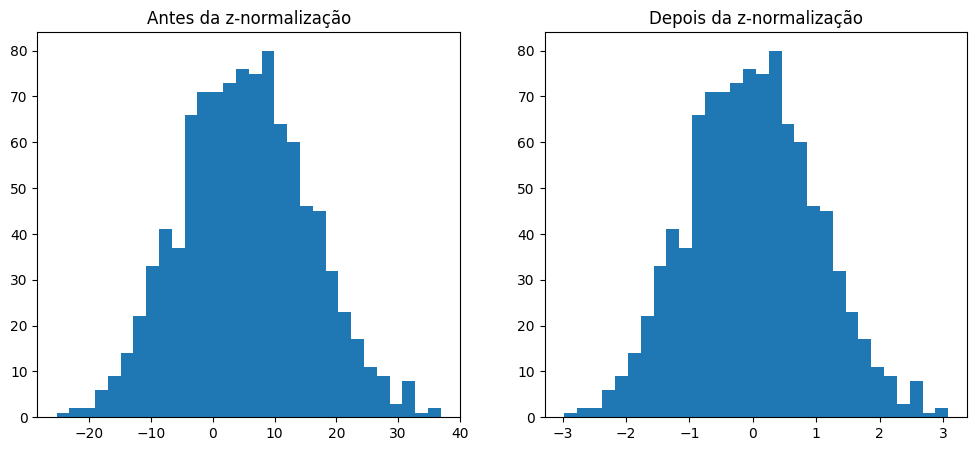

Média antes: 5.3102
Desvio padrão antes: 10.2564
Média depois: -0.0000
Desvio padrão depois: 1.0005


In [2]:
import torch
import matplotlib.pyplot as plt

# Implementação da z-normalização
def z_normalize(x: torch.Tensor) -> torch.Tensor:
    """
    Standard‑score normalization: (x – μ) / σ
    """
    mean = x.mean()
    std  = x.std(unbiased=False)  # population std for consistency
    return (x - mean) / std

# Dados sintéticos e visualização
x = torch.randn(1000) * 10 + 5
x_norm = z_normalize(x)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Antes da z-normalização')
plt.hist(x.numpy(), bins=30)
plt.subplot(1,2,2)
plt.title('Depois da z-normalização')
plt.hist(x_norm.numpy(), bins=30)
plt.show()

# Verificação de média e desvio padrão
print(f"Média antes: {x.mean().item():.4f}")
print(f"Desvio padrão antes: {x.std().item():.4f}")

print(f"Média depois: {x_norm.mean().item():.4f}")
print(f"Desvio padrão depois: {x_norm.std().item():.4f}")


### Pergunta teórica
1. O que significa normalizar um vetor com Z-score?
2. Por que isso ajuda no treinamento de redes neurais?

---

## 2. Implementação de Camadas de Normalização

Neste exercício vamos implementar as diferentes camadas de normalização vistas na aula e comparar a nossa implementação com a do Pytorch.


**Abaixo está um exemplo com a layer normalization:**

In [3]:
import torch
import torch.nn.functional as F
from torch import nn

# Exemplo: implementação manual de LayerNorm
def layer_norm_manual(x: torch.Tensor, eps: float = 1e-5):
    # x: (N, C, H, W)
    dims = [1,2,3]
    mean = x.mean(dim=dims, keepdim=True)
    var = x.var(dim=dims, keepdim=True, unbiased=False)
    return (x - mean) / torch.sqrt(var + eps)

# Teste comparativo
x = torch.randn(4, 3, 32, 32)
ln = nn.LayerNorm([3,32,32])
out_manual = layer_norm_manual(x)
out_torch = ln(x)
print('Erro MAE LayerNorm:', torch.abs(out_manual - out_torch).mean().item())

Erro MAE LayerNorm: 2.619493422173491e-08



Agora é a sua vez (exercício difícil)!

Implemente manualmente cada uma das funções de normalização apresentadas na aula e compare-a com a implementação do Pytorch:

- **BatchNorm2d:** média e variância em (N, H, W) para cada canal.
- **InstanceNorm2d:** média e variância em (H, W) para cada instância e canal.
- **GroupNorm:** divida C em grupos e calcule por grupo.
- **RMSNorm:** normalize pela raiz da média quadrática sem subtrair média.

In [4]:
import torch
from torch import nn

# ------------ 1. BatchNorm2d ------------ #
def batch_norm2d_manual(x: torch.Tensor, eps: float = 1e-5):
    # stats over batch + spatial dims, per channel
    mean = x.mean(dim=(0, 2, 3), keepdim=True)
    var  = x.var(dim=(0, 2, 3), keepdim=True, unbiased=False)
    return (x - mean) / torch.sqrt(var + eps)

# ------------ 2. InstanceNorm2d ------------ #
def instance_norm2d_manual(x: torch.Tensor, eps: float = 1e-5):
    # stats over spatial dims, per sample & channel
    mean = x.mean(dim=(2, 3), keepdim=True)
    var  = x.var(dim=(2, 3), keepdim=True, unbiased=False)
    return (x - mean) / torch.sqrt(var + eps)

# ------------ 3. GroupNorm ------------ #
def group_norm_manual(x: torch.Tensor, num_groups: int, eps: float = 1e-5):
    N, C, H, W = x.shape
    assert C % num_groups == 0, "C must be divisible by num_groups"
    x = x.view(N, num_groups, C // num_groups, H, W)
    mean = x.mean(dim=(2, 3, 4), keepdim=True)
    var  = x.var(dim=(2, 3, 4), keepdim=True, unbiased=False)
    x_norm = (x - mean) / torch.sqrt(var + eps)
    return x_norm.view(N, C, H, W)

# ------------ 4. RMSNorm (no mean subtraction) ------------ #
def rms_norm_manual(x: torch.Tensor, eps: float = 1e-5):
    # normalise by root‑mean‑square across last D dims (all but batch)
    rms = torch.sqrt(torch.mean(x**2, dim=tuple(range(1, x.dim())), keepdim=True) + eps)
    return x / rms


In [5]:
x = torch.randn(4, 8, 32, 32)

# BatchNorm2d
bn_man  = batch_norm2d_manual(x)
bn_torch = nn.BatchNorm2d(8, affine=False, track_running_stats=False)(x)
print("BatchNorm MAE:", (bn_man - bn_torch).abs().mean().item())

# InstanceNorm2d
in_man  = instance_norm2d_manual(x)
in_torch = nn.InstanceNorm2d(8, affine=False, track_running_stats=False)(x)
print("InstanceNorm MAE:", (in_man - in_torch).abs().mean().item())

# GroupNorm (e.g. 4 groups)
gn_man  = group_norm_manual(x, num_groups=4)
gn_torch = nn.GroupNorm(4, 8, affine=False)(x)
print("GroupNorm MAE:", (gn_man - gn_torch).abs().mean().item())

# RMSNorm: compare against reference implementation
def rms_norm_ref(x, eps=1e-5):
    rms = torch.sqrt(torch.mean(x**2, dim=tuple(range(1, x.dim())), keepdim=True) + eps)
    return x / rms
print("RMSNorm MAE:", (rms_norm_manual(x) - rms_norm_ref(x)).abs().mean().item())


BatchNorm MAE: 2.844080881914124e-08
InstanceNorm MAE: 3.3442081104340105e-08
GroupNorm MAE: 2.727947290281918e-08
RMSNorm MAE: 0.0



### Pergunta teórica
1. O que acontece na batch norm caso o tamanho do batch seja pequeno?
2. Onde cada uma das funções do normalizações acima é mais usada e por que?

---

## 3. Dynamic Tanh vs. Normalização

Implemente a função DynTanH conforme apresentada na aula.

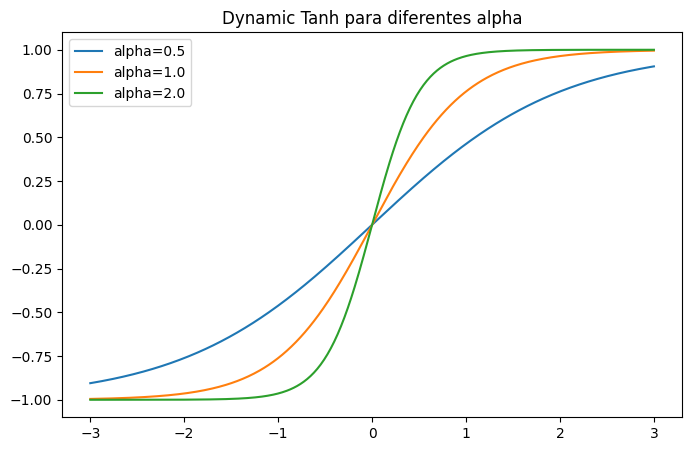

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Implemente aqui
import torch

def dyn_tanh(x: torch.Tensor,
             alpha: float,
             gamma: float = 1.0,
             beta:  float = 0.0) -> torch.Tensor:
    """
    Dynamic Tanh (DyT)
    y = γ · tanh(α · x) + β

    • alpha (α)  – learnable/global scaling that adapts to the input range
    • gamma (γ)  – learnable per‑channel gain (like LayerNorm’s weight)
    • beta  (β)  – learnable per‑channel bias (like LayerNorm’s bias)
    """
    # ensure broadcastable tensors
    alpha = torch.as_tensor(alpha, dtype=x.dtype, device=x.device)
    gamma = torch.as_tensor(gamma, dtype=x.dtype, device=x.device)
    beta  = torch.as_tensor(beta,  dtype=x.dtype, device=x.device)
    return gamma * torch.tanh(alpha * x) + beta


x = torch.linspace(-3,3,500)
plt.figure(figsize=(8,5))
for alpha in [0.5, 1.0, 2.0]:
    y = dyn_tanh(x, alpha, gamma=1, beta=0)
    plt.plot(x.numpy(), y.numpy(), label=f'alpha={alpha}')
plt.title('Dynamic Tanh para diferentes alpha')
plt.legend()
plt.show()

---

## 4. Benchmark de Tempo e Parâmetros

Compare o tempo de execução e o número de parâmetros das funções de normalização estudadas.


In [8]:
import timeit
from torch import nn

C, H, W = 64, 32, 32
tensor = torch.randn(32, C, H, W)
modules = {
    'BatchNorm2d': nn.BatchNorm2d(C), # Initialize with a BatchNorm2d instance
    'LayerNorm': nn.LayerNorm([C, H, W]), # Initialize with a LayerNorm instance
    'InstanceNorm2d': nn.InstanceNorm2d(C), # Initialize with an InstanceNorm2d instance
    'GroupNorm': nn.GroupNorm(num_groups=32, num_channels=C), # Initialize with a GroupNorm instance - using 32 groups as an example
    'RMSNorm': lambda x: x / torch.sqrt(torch.mean(x**2, dim=tuple(range(1, x.dim())), keepdim=True) + 1e-5), #Custom RMSNorm as it is not directly in PyTorch
}

for name, mod in modules.items():
    _ = mod(tensor)
    t = timeit.timeit(lambda: mod(tensor), number=100)
    if name != 'RMSNorm': #RMSNorm is a lambda function, not a nn.Module
        params = sum(p.numel() for p in mod.parameters() if p.requires_grad)
    else:
        params = 0
    print(f"{name}: tempo médio {t/100*1000:.3f} ms, parâmetros {params}")

BatchNorm2d: tempo médio 9.809 ms, parâmetros 128
LayerNorm: tempo médio 4.098 ms, parâmetros 131072
InstanceNorm2d: tempo médio 8.997 ms, parâmetros 0
GroupNorm: tempo médio 2.896 ms, parâmetros 128
RMSNorm: tempo médio 3.434 ms, parâmetros 0


---

## 5. Experimento Final: Treinamento com Diferentes Normalizações

**Agora é a sua vez!!**

Escolhe um problema, instancie o dataset e treine um modelo com as diferentes funções de normalização estudadas. Compare a convergencia do treinamento e o resultado obtido com cada uma delas!

In [9]:
from torchvision import datasets, transforms
train_t = transforms.Compose([transforms.ToTensor()])
test_t  = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.CIFAR10(root='data', train=True , download=True, transform=train_t)
test_ds  = datasets.CIFAR10(root='data', train=False, download=True, transform=test_t)


100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


In [10]:
import torch.nn as nn

def get_norm(norm_type: str, num_ch: int):
    if norm_type == "batch":      return nn.BatchNorm2d(num_ch)
    if norm_type == "instance":   return nn.InstanceNorm2d(num_ch)
    if norm_type == "layer":      return nn.GroupNorm(1, num_ch)       # LayerNorm 2D
    if norm_type == "group":      return nn.GroupNorm(4, num_ch)       # divide em 4 grupos
    if norm_type == "rms":        return nn.RMSNorm(num_ch)            # PyTorch ≥2.4
    raise ValueError(f"Norm {norm_type} não suportada")


In [11]:
class SmallCNN(nn.Module):
    def __init__(self, norm_type="batch"):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  get_norm(norm_type, 32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), get_norm(norm_type, 64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), get_norm(norm_type, 128), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x): return self.net(x)


In [12]:
def train(model, optim, loader, device):
    model.train(); loss_fn = nn.CrossEntropyLoss(); acc, tot = 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optim.zero_grad()
        out = model(x); loss = loss_fn(out, y); loss.backward(); optim.step()
        acc += (out.argmax(1) == y).sum().item(); tot += y.size(0)
    return loss.item(), acc / tot


In [ ]:
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
load_train = DataLoader(train_ds, batch_size=128, shuffle=True)

norms = ["batch", "instance", "layer", "group", "rms"]
results = {}

for n in norms:
    model = SmallCNN(norm_type=n).to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
    losses, accs = [], []
    for epoch in range(10):                        # treine rápido (10 épocas)
        loss, acc = train(model, optim, load_train, device)
        losses.append(loss); accs.append(acc)
    results[n] = {"loss": losses, "acc": accs}


In [ ]:
import matplotlib.pyplot as plt
for metric in ["loss", "acc"]:
    plt.figure(figsize=(6,4))
    for n in norms:
        plt.plot(results[n][metric], label=n)
    plt.title(metric.upper()); plt.legend(); plt.show()
